Let's train the guy

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
tf.keras.backend.set_floatx('float32')
from collections import deque
from datetime import datetime
import random
import matplotlib
from environment import Environment
from plots import just_plot
from misc import *
from nets import *
from buffer import ReplayBuffer


amplitude=0.4
tau = 0.1
lr_critic = 10**-2/2
lr_actor=10**-5
noise_displacement = .25
ep_guess=0.01
dolinar_layers=1
number_phases=2
buffer_size = 10**7


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = Critic(nature="primary",valreg=0.01, dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = Actor(nature="primary", dolinar_layers = dolinar_layers)
actor_target = Actor(nature="target", dolinar_layers = dolinar_layers)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)

policy_evaluator = PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)

expes = np.load("buffers/1L-stoch.npy")

for k in tqdm(expes):
    buffer.add(tuple(k))

def plot(critic, episode = 1, last_episode=False, max_episode=10**4, history_betas =[]):

    betas = np.arange(.1,1.1,.05)
    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), alpha=min(episode/max_episode,1), linewidth=5,label="RNN - "+str(episode))

    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], alpha=min(episode/max_episode,1), linewidth=5,label="RNN" +str(episode))
            
            
    if last_episode:
        betas = np.arange(.1,1.1,.05)
        inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
        inps = np.reshape(inps, (len(betas),1,2))
        ax3.plot(betas, np.squeeze(critic(inps)), linewidth=8,c="black",label="RNN")


        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1],c="black", linewidth=8,label="RNN")


        ax1.plot(betas,[qval(b, 0, -1) for b in betas],c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas,[qval(b, 0, 1) for b in betas],c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas,[qval(b, 1, -1) for b in betas],c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas,[qval(b, 1, 1) for b in betas],c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

        ax3.plot(betas,ps_maxlik(betas), '--', linewidth=5, color="red", label="P*")
        ax4.plot(np.arange(1,len(history_betas)+1), history_betas, alpha=0.75, c="red", linewidth=7)
        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel(r'$\beta$', size=20)


100%|██████████| 5000/5000 [00:00<00:00, 540043.78it/s]


  1%|          | 1/100 [00:43<1:11:37, 43.41s/it]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


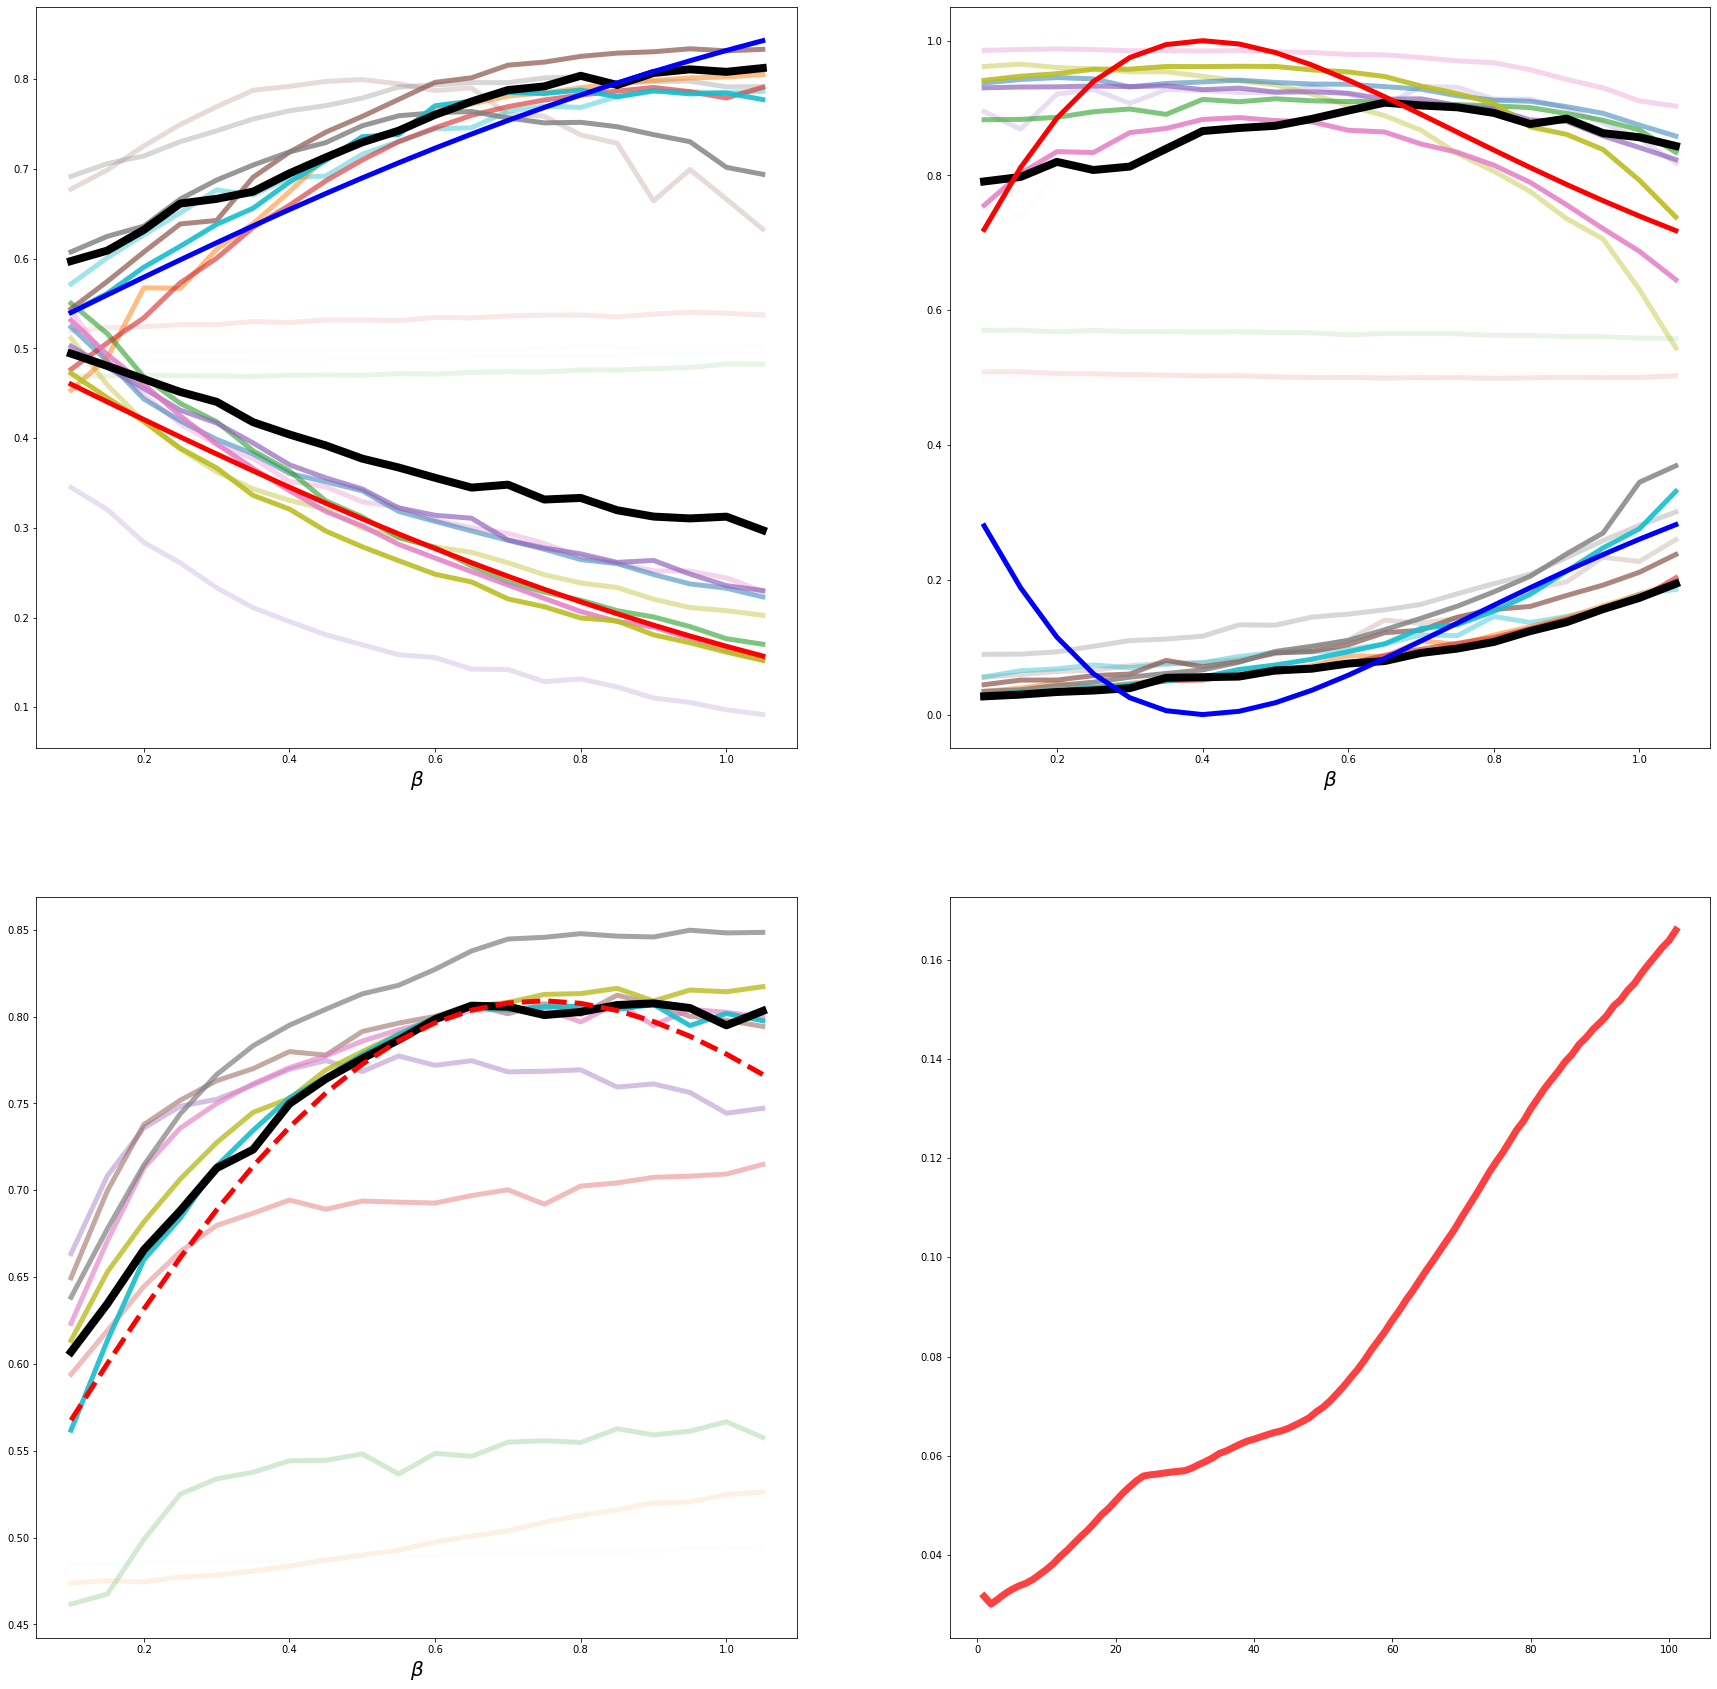

In [2]:
plt.figure(figsize=(30,30))


ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0))
ax4 = plt.subplot2grid((2,2),(1,1))

axes = {"0.0":ax1, "1.0":ax2}


loss_ev = []
history_betas = []
total_episodes = 10**2
batch_size = 512           

context_outcome_actor = np.reshape(np.array([actor.pad_value]),(1,1,1)).astype(np.float32)
history_betas.append(np.squeeze(actor(context_outcome_actor)[0]))
   
for k in tqdm(range(total_episodes)):
    experiences = buffer.sample(batch_size).astype(np.float32)
    samples, zerolabs = critic_target.process_sequence_tf(experiences)
    labels_critic = critic_target.give_td_errors_tf( samples, zerolabs)
    loss_critic = step_critic_tf(samples ,labels_critic, critic, optimizer_critic)
    critic_target.update_target_parameters(critic)
    loss_ev.append(loss_critic.numpy())
    #### actor ####
    
    actor.lstm.stateful=False
    actor.reset_states_workaround(new_batch_size=int(batch_size))
    
    dq_da = critic_grad_tf(critic, experiences)
    actor_grad_tf(actor, dq_da, experiences, optimizer_actor)
    
    actor.reset_states_workaround(new_batch_size=1)
    actor.lstm.stateful=True

    context_outcome_actor = np.reshape(np.array([actor.pad_value]),(1,1,1)).astype(np.float32)
    history_betas.append(np.squeeze(actor(context_outcome_actor)[0]))
    
    if k%int(total_episodes/10)==1:
        plot(critic, episode=k, last_episode=False, max_episode = total_episodes)
plot(critic, episode=k, last_episode=True, history_betas=history_betas)    